In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import sys
import os
import time

from PIL import Image
from IPython import display

import umap
import pickle
from math import *
import random

DEVICE = "cuda"

def tovar(x):
    return torch.FloatTensor(x).to(DEVICE)

In [2]:
class Node():
    def __init__(self, k, depth, p_term, p_count, maxdepth=3):
        super().__init__()
        
        self.variable = np.random.randint(k+1)
        if self.variable == 0:
            self.threshold = np.random.randint(k)
        else:
            self.threshold = np.random.choice(np.arange(9), p=p_count)
            
        self.operation = np.random.randint(2) # Equality, >=
        
        if depth == maxdepth:
            self.children = [np.random.randint(k), np.random.randint(k)]
        else:            
            self.children = []
            for i in range(2):
                if np.random.rand()<p_term:
                    self.children.append(np.random.randint(k))
                else:
                    self.children.append(Node(k,depth+1,p_term,p_count,maxdepth))
            
    def forward(self, x):
        if self.operation == 0:
            if x[self.variable] == self.threshold:
                branch = 1
            else:
                branch = 0
        elif self.operation == 1:
            if x[self.variable] >= self.threshold:
                branch = 1
            else:
                branch = 0
        
        child = self.children[branch]
        
        if isinstance(child, Node):
            return child.forward(x)
        else:
            return child

class EightNeighbor():
    def __init__(self, colors):
        self.colors = colors
        
        # 8 neighbor outer symmetric
        # 
        # k (center) * 9^k (outer [0,...,8] for each color)
        self.transitions = torch.LongTensor(np.random.randint(colors, size=(colors * 9**colors))).to(DEVICE)
    
    def tree_transition(self, depth, p_term, p_count):
        tree = Node(self.colors, 1, p_term, p_count, maxdepth=depth)
        transitions = np.zeros((self.colors * 9**self.colors))
        
        for i in range(self.colors * 9**self.colors):
            idx = np.zeros((1+self.colors,)).astype(np.int32)
            
            mult = 1
            idx[0] = (i//mult)%self.colors
            mult *= self.colors
            for k in range(self.colors):
                idx[k+1] = (i//mult)%9
                mult *= 9
            
            transitions[i] = tree.forward(idx)
        
        self.transitions = torch.LongTensor(transitions).to(DEVICE)
        
    def step(self, state):
        XR = state.shape[0]
        YR = state.shape[1]
        
        self.state = torch.LongTensor(state).to(DEVICE)
        idx = torch.arange(XR*YR).long().to(DEVICE)

        padstate = torch.cat([self.state[-1:,:], self.state, self.state[:1,:]], 0)
        padstate = torch.cat([padstate[:,-1:], padstate, padstate[:,:1]], 1)

        multiplier = int(self.colors)
        indices = self.state.view(XR*YR).long()

        histogram = torch.zeros((XR*YR, self.colors)).long().to(DEVICE)

        shiftstate = padstate[:-2,1:-1].contiguous().view(XR*YR)
        histogram[idx, shiftstate[idx]] += 1
        shiftstate = padstate[2:,1:-1].contiguous().view(XR*YR)
        histogram[idx, shiftstate[idx]] += 1
        shiftstate = padstate[1:-1,:-2].contiguous().view(XR*YR)
        histogram[idx, shiftstate[idx]] += 1
        shiftstate = padstate[1:-1,2:].contiguous().view(XR*YR)
        histogram[idx, shiftstate[idx]] += 1
            
        shiftstate = padstate[:-2,:-2].contiguous().view(XR*YR)
        histogram[idx, shiftstate[idx]] += 1
        shiftstate = padstate[:-2,2:].contiguous().view(XR*YR)
        histogram[idx, shiftstate[idx]] += 1
        shiftstate = padstate[2:,:-2].contiguous().view(XR*YR)
        histogram[idx, shiftstate[idx]] += 1
        shiftstate = padstate[2:,2:].contiguous().view(XR*YR)
        histogram[idx, shiftstate[idx]] += 1

        for k in range(self.colors):
            indices += multiplier * histogram[:,k] 
            multiplier *= 9

        result = self.transitions[indices].view(XR, YR)
        
        return result.cpu().detach().numpy()

In [3]:
class Triplet(nn.Module):
    def __init__(self):
        super(Triplet,self).__init__()
        
        self.l1a = nn.Conv3d(3,32,5,padding=2)
        nn.init.orthogonal_(self.l1a.weight, gain=sqrt(2))
        self.b1a = nn.BatchNorm3d(32)
        self.l1b = nn.Conv3d(32,32,5,padding=2)
        self.b1b = nn.BatchNorm3d(32)
        nn.init.orthogonal_(self.l1b.weight, gain=sqrt(2))
        self.p1 = nn.MaxPool3d(2)
        
        self.l2a = nn.Conv3d(32,64,5,padding=2)
        self.b2a = nn.BatchNorm3d(64)
        nn.init.orthogonal_(self.l2a.weight, gain=sqrt(2))
        self.l2b = nn.Conv3d(64,64,5,padding=2)
        self.b2b = nn.BatchNorm3d(64)
        nn.init.orthogonal_(self.l2b.weight, gain=sqrt(2))
        self.p2 = nn.MaxPool3d(2)

        self.l3a = nn.Conv3d(64,128,5,padding=2)
        self.b3a = nn.BatchNorm3d(128)
        nn.init.orthogonal_(self.l3a.weight, gain=sqrt(2))
        self.l3b = nn.Conv3d(128,128,5,padding=2)
        self.b3b = nn.BatchNorm3d(128)
        nn.init.orthogonal_(self.l3b.weight, gain=sqrt(2))
        self.p3 = nn.MaxPool3d(2)
        
        self.l4a = nn.Conv3d(128,256,5,padding=2)
        self.b4a = nn.BatchNorm3d(256)
        nn.init.orthogonal_(self.l4a.weight, gain=sqrt(2))
        self.l4b = nn.Conv3d(256,256,5,padding=2)
        self.b4b = nn.BatchNorm3d(256)
        nn.init.orthogonal_(self.l4b.weight, gain=sqrt(2))
        self.p4 = nn.MaxPool3d(2)
        
        self.l5 = nn.Linear(256,16,1)
        nn.init.orthogonal_(self.l5.weight, gain=sqrt(2))
        
        self.optim = torch.optim.Adam(self.parameters(), lr=1e-4)
        
    def forward(self, x):
        z = x
        z = F.leaky_relu(self.l1a(z))
        z = self.b1a(z)
        z = F.leaky_relu(self.l1b(z))
        z = self.b1b(z)
        z = self.p1(z)
        
        z = F.leaky_relu(self.l2a(z))
        z = self.b2a(z)
        z = F.leaky_relu(self.l2b(z))
        z = self.b2b(z)
        z = self.p2(z)
        
        z = F.leaky_relu(self.l3a(z))
        z = self.b3a(z)
        z = F.leaky_relu(self.l3b(z))
        z = self.b3b(z)
        z = self.p3(z)
        
        z = F.leaky_relu(self.l4a(z))
        z = self.b4a(z)
        z = F.leaky_relu(self.l4b(z))
        z = self.b4b(z)
        z = self.p4(z).mean(4).mean(3).mean(2)
        
        z = self.l5(z)
        z = z/torch.sqrt(torch.sum(z**2,1)+1e-4).unsqueeze(1)
        
        return z
    
net = Triplet().cuda()
net.load_state_dict(torch.load("triplet_ca_2d_multitype2.pth"))
net.eval()

clf = pickle.load(open("umap_classifier_multi_4.pkl","rb"))

In [4]:
def generate_palette(k):
    stop = False
    
    while not stop:
        rgb = np.random.rand(k,3)
        dist = np.sum(np.abs(rgb[np.newaxis,:,:] - rgb[:,np.newaxis,:]),axis=2)
        dist[np.arange(k), np.arange(k)] += 10
        mindist = np.min(dist)
        if mindist > 0.75:
            stop = True
    
    return rgb

def totensor(history):
    XR = history.shape[1]
    YR = history.shape[0]
    TR = history.shape[2]
    
    hist = history.transpose(1,0,2).reshape((XR*YR*TR))
    
    im = 2*rgb[hist]-0.5
    im = im.transpose(1,0).reshape((1,3,XR,YR,TR))
    return tovar(im)

rgb = generate_palette(4)

In [34]:
def evalFitness(params):    
    UMIN = -20
    UMAX = 20
    VMIN = -20
    VMAX = 20
    BINS = 8

    density = np.zeros((BINS,BINS))
    
    for i in range(50):
        ca = EightNeighbor(4)
        
        depth = int(1 + 7 * (1-cos(pi * params[0]/10))/2)
        p_term = 0 + 1*(1-cos(pi * params[1]/10))/2
        p_count = 0 + 1 * (1-np.cos(pi * np.array(params[2:]) / 10))/2
        p_count = p_count/np.sum(p_count)
        
        ca.tree_transition(depth, p_term, p_count)
        
        state = np.random.randint(3, size=(128,128))
        history = np.zeros((128,128,16)).astype(np.uint8)
        
        for j in range(10):
            state = ca.step(state)
            
        for j in range(16):
            state = ca.step(state)
            history[:,:,j] = state.copy()
            
        z = totensor(history)
        latent = net.forward(z).cpu().detach().numpy()
        latent = clf.transform(latent)

        u = int(np.clip(BINS*(latent[0,0]-UMIN)/(UMAX-UMIN),0,BINS-1))
        v = int(np.clip(BINS*(latent[0,1]-VMIN)/(VMAX-VMIN),0,BINS-1))
        density[u,v] += 1.0/50.0
    
    H = -np.sum(density*np.log(density+1e-8))
    
    return H, density

In [21]:
import cma

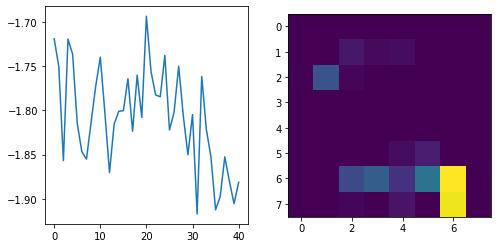

KeyboardInterrupt: 

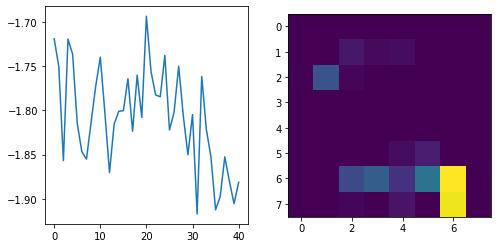

In [35]:
import tqdm

fitness = []

optim = cma.CMAEvolutionStrategy(mu, 1)

for epoch in range(10000):
    params = optim.ask()
    results = []
    density = np.zeros((8,8))
    
    for p in tqdm.tqdm_notebook(params):
        H, ddense = evalFitness(p)
        results.append(-H)
        density = density + ddense
        
    optim.tell(params, results)
    
    fitness.append(np.mean(results))
    
    plt.clf()
    plt.subplot(1,2,1)
    plt.plot(fitness)
    
    plt.subplot(1,2,2)
    plt.imshow(density)
    
    plt.gcf().set_size_inches((8,4))
    display.clear_output(wait=True)
    display.display(plt.gcf())
    time.sleep(0.01)
    

In [36]:
def parseParams(params):
    depth = int(1 + 7 * (1-cos(pi * params[0]/10))/2)
    p_term = 0 + 1*(1-cos(pi * params[1]/10))/2
    p_count = 0 + 1 * (1-np.cos(pi * np.array(params[2:]) / 10))/2
    p_count = p_count/np.sum(p_count)
    
    return depth, p_term, p_count

In [37]:
mu = np.mean(params, axis=0)

In [38]:
d, p_t, p_c = parseParams(mu)

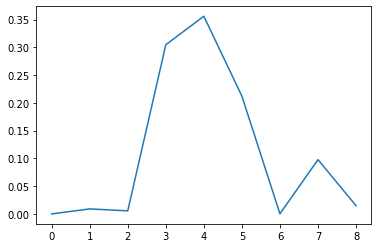

In [39]:
plt.plot(p_c)

In [40]:
d

7

In [41]:
p_t

0.0016727503757000828

In [42]:
p_c

array([9.72736697e-06, 9.03122565e-03, 5.52199926e-03, 3.04649606e-01,
       3.55919120e-01, 2.12032503e-01, 2.52099668e-04, 9.77000900e-02,
       1.48836294e-02])